In [ ]:
import torch
import torchvision

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(
                                      (0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_test, shuffle=True
)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1000, 1, 28, 28])

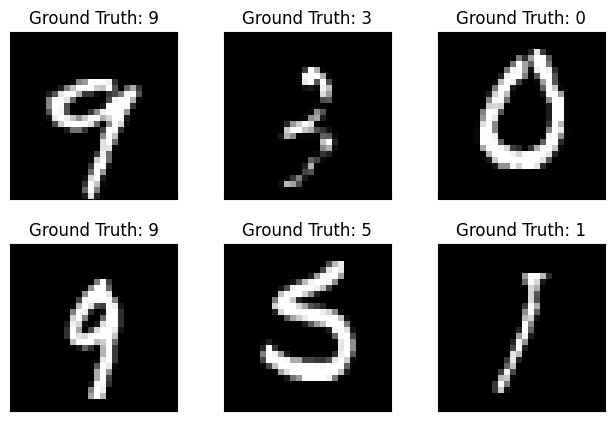

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
from torch import nn

Origin: 1, 28, 28

In block 1:
 - Conv2d -> 10, 24, 24
 - max_pool2d -> 10, 12, 12

In block 2:
 - Conv2d -> 20, 8, 8
 - max_pool2d -> 20, 4, 4

view (flattern): 20 x 4 x 4 = 320

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            #nn.functional.max_pool2d(kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            #nn.functional.relu()
            nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
            nn.Dropout2d(),
            #nn.functional.max_pool2d(kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            ##nn.functional.relu()
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=320, out_features=50),
            ##nn.functional.relu(),
            nn.ReLU(),
            ##nn.functional.dropout(training=self.training),
            nn.Dropout(),
            nn.Linear(in_features=50, out_features=10)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = x.view(-1, 320)
        x = self.classifier(x)
        return nn.functional.log_softmax(x)

In [ ]:
network = Net()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate,
                            momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)

        loss = loss_fn(output, target)
        loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0

    with torch.inference_mode():
        for data, target in test_loader:
            output = network(data)
            test_loss += loss_fn(output, target)

            #print(output.data.max(1, keepdim=True))
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-8-cfecfb6dbeb7>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)



Test set: Avg. loss: 0.0023, Accuracy: 732/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307091
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.282725
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.257458
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.280287
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266104
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.208426
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.200735
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.180939
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.158252
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.131378
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.980509
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.919517
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.768464
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.883227
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.768278
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.390756
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.428801
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.412834
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.254577
Train Epoch: 1 [12160/6

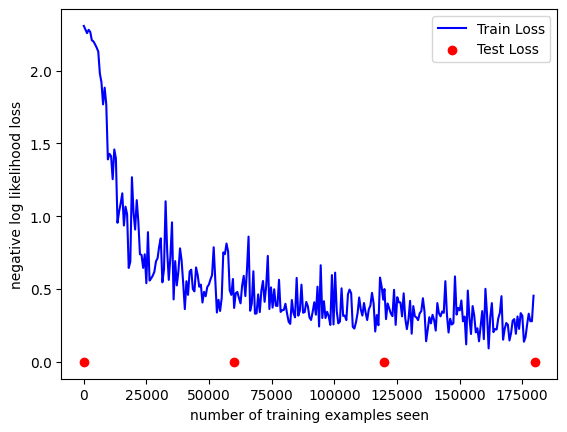

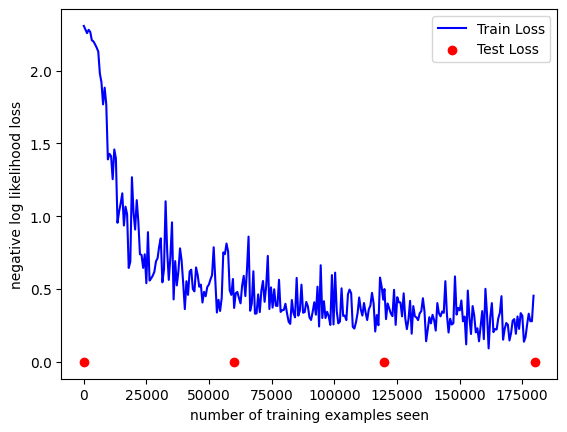

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig